The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs.

In [32]:
# Import necessary libraries and set display options
# Import necessary libraries
import importlib
from matplotlib.ticker import LogLocator, FuncFormatter
from scipy.integrate import quad
# Import GPD specific functions
import sys
sys.path.append('/mnt/c/Users/flori/Documents/PostDoc/Jupyter')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from joblib import Parallel, delayed
from scipy.special import gamma, digamma,hyp2f1
import mpmath as mp
import re
import os
import time
from GPD_functions import *

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set width to avoid wrapping
pd.set_option('display.max_colwidth', None) # Show full content of each column

np.set_printoptions(linewidth=200)

In [33]:
# Reload if GPD_functions has been changed
# Define the module name
module_name = 'GPD_functions'

# Remove the module from sys.modules to force a full reload
if module_name in sys.modules:
    del sys.modules[module_name]

# Re-import the module using importlib
importlib.import_module(module_name)

# Now, reload the module to get the updated content
importlib.reload(sys.modules[module_name])

<module 'GPD_functions' from '/mnt/c/Users/flori/Documents/PostDoc/Jupyter/GPD_functions.py'>

In [2]:
# Check if data files are parsed correctly
for ID in publication_mapping:
    moment_type = "NonSingletIsovector"
    #moment_type = "NonSingletIsoscalar"
    moment_label = "A"
    
    print(f"Publication ID: {ID}")
    
    # Get the t_values and check if it's valid
    t_vals = t_values(moment_type, moment_label, ID)
    if t_vals is not None:
        print("t_values:", t_vals)
    else:
        continue
    
    # Iterate through n from 1 to 5
    for n in range(1, 6):
        print(f"Checking n = {n}")
        
        # Get the F{n}0 moment_type values and check if it's valid
        Fn0_vals = Fn0_values(n, moment_type, moment_label, ID)
        if Fn0_vals is not None:
            print(f"{moment_label}{n}0 {moment_type} values:", Fn0_vals)
        else:
            print(f"{moment_label}{n}0 {moment_type} values: No data available.")
        
        # Get the F{n}0 moment_type errors and check if it's valid
        Fn0_errs = Fn0_errors(n, moment_type, moment_label, ID)
        if Fn0_errs is not None:
            print(f"{moment_label}{n}0 {moment_type} errors:", Fn0_errs)
        else:
            print(f"{moment_label}{n}0 {moment_type} errors: No data available.")    

Publication ID: 2305.11117
t_values: [0.17 0.34 0.65 0.69 0.81 1.24 1.38 1.38 1.52 2.29 2.77]
Checking n = 1
A10 NonSingletIsovector values: [0.851 0.702 0.607 0.573 0.487 0.359 0.396 0.376 0.32  0.266 0.214]
A10 NonSingletIsovector errors: [0.0311 0.043  0.024  0.0146 0.031  0.0371 0.0042 0.021  0.0371 0.0662 0.013 ]
Checking n = 2
A20 NonSingletIsovector values: [0.247 0.205 0.193 0.187 0.168 0.145 0.137 0.129 0.131 0.115 0.101]
A20 NonSingletIsovector errors: [0.0117 0.0032 0.0098 0.0076 0.0092 0.012  0.0122 0.0092 0.014  0.0282 0.0071]
Checking n = 3
A30 NonSingletIsovector values: [0.086 0.078 0.068 0.07  0.068 0.064 0.053 0.05  0.047 0.048 0.035]
A30 NonSingletIsovector errors: [0.005  0.0054 0.0051 0.0054 0.0041 0.0063 0.0067 0.0041 0.0076 0.0149 0.0041]
Checking n = 4
A40 NonSingletIsovector values: [0.042 0.038 0.036 0.029 0.03  0.026 0.023 0.026 0.019 0.026 0.018]
A40 NonSingletIsovector errors: [0.0058 0.005  0.0054 0.0058 0.0042 0.0045 0.0036 0.0028 0.0041 0.0089 0.0036]
Ch

In [3]:
# Display the DataFrame
print("Parsed DataFrame:")
display(MSTWpdf)

Parsed DataFrame:


,Parameter,LO,NLO,NNLO
0,alpha_S(Q0^2),"[0.68183, 0, 0]","[0.49128, 0, 0]","[0.45077, 0, 0]"
1,alpha_S(M_Z^2),"[0.13939, 0, 0]","[0.12018, 0, 0]","[0.11707, 0, 0]"
2,A_u,"[1.4335, 0, 0]","[0.25871, 0, 0]","[0.2225, 0, 0]"
3,eta_1,"[0.45232, 0.022, -0.018]","[0.29065, 0.019, -0.013]","[0.27871, 0.018, -0.014]"
4,eta_2,"[3.0409, 0.079, -0.067]","[3.2432, 0.062, -0.039]","[3.3627, 0.061, -0.044]"
5,epsilon_u,"[-2.3737, 0.54, -0.48]","[4.0603, 1.6, -2.3]","[4.4343, 2.4, -2.7]"
6,gamma_u,"[8.9924, 0, 0]","[30.687, 0, 0]","[38.599, 0, 0]"
7,A_d,"[5.0903, 0, 0]","[12.288, 0, 0]","[17.938, 0, 0]"
8,eta_3,"[0.71978, 0.057, -0.082]","[0.96809, 0.11, -0.11]","[1.0839, 0.12, -0.11]"
9,eta_4-eta_2,"[2.0835, 0.32, -0.45]","[2.7003, 0.5, -0.52]","[2.7865, 0.5, -0.44]"


In [4]:
# Check momentum sum rule
def integrand(x):
    return x*(uv(x)+dv(x)+sv(x)+Sv(x)+gv(x))
result, error = quad(integrand,1e-6,1)
print(f"Check momentum sum rule")
print(np.isclose(result,1,rtol=1e-3,atol=1e-3))
del integrand, result, error

Check momentum sum rule
True


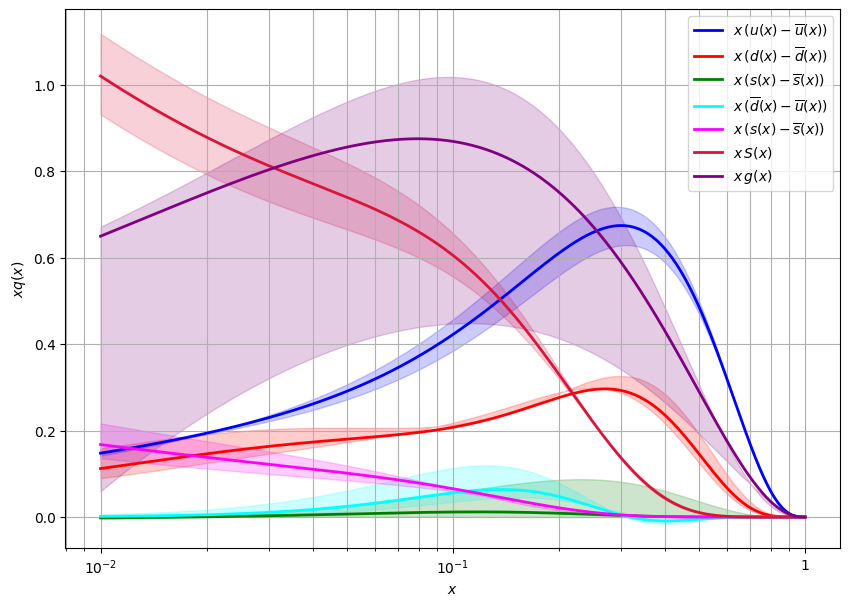

In [5]:
# Log Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.geomspace(1e-2, 1, 1000)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Customize ticks and labels
# Custom formatter function
def custom_log_formatter(val, pos):
    if val == 1:  # 10^0
        return "1"
    else:
        return f"$10^{{{int(np.log10(val))}}}$"
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0))  # Major ticks at 10^n
plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_log_formatter))

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True,which="both")

# Display the plot
plt.show()


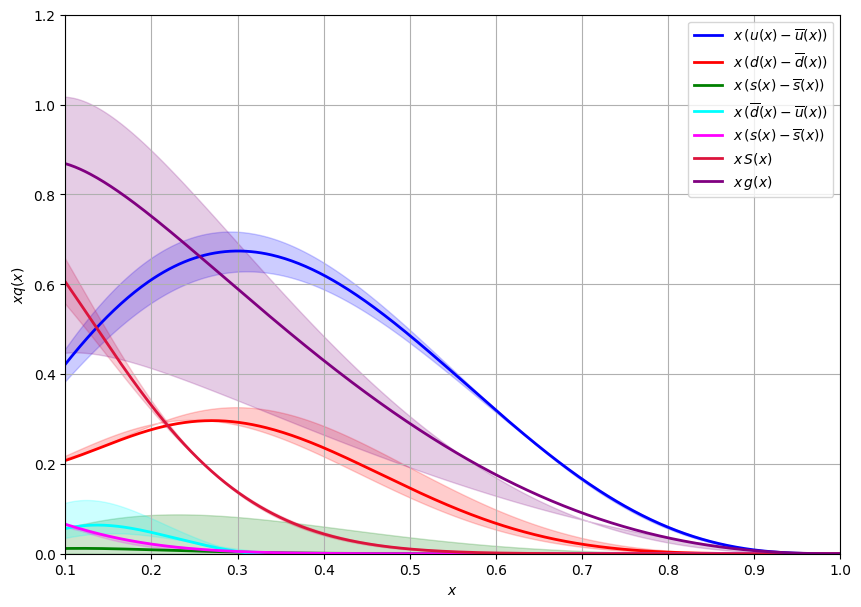

In [6]:
# Linear Plot of PDFs
# Define the range for x from 10^-2 to 1
x_values = np.linspace(1e-2, 1, 500)

# Calculate uv(x) for the central value, plus and minus errors
x_uv_central = x_values * uv(x_values, "central")
x_uv_plus = x_values * uv(x_values, "plus")
x_uv_minus = x_values * uv(x_values, "minus")

# Define dv(x) for the central value, plus and minus errors
x_dv_central = x_values * dv(x_values, "central")
x_dv_plus = x_values * dv(x_values, "plus")
x_dv_minus = x_values * dv(x_values, "minus")

# Define sv(x) for the central value, plus and minus errors
x_sv_central = x_values * sv(x_values, "central")
x_sv_plus = x_values * sv(x_values, "plus")
x_sv_minus = x_values * sv(x_values, "minus")

# Define s_+(x) for the central value, plus and minus errors
x_s_p_central = x_values * s_plus(x_values, "central")
x_s_p_plus = x_values * s_plus(x_values, "plus")
x_s_p_minus = x_values * s_plus(x_values, "minus")

# Define Sv(x) for the central value, plus and minus errors
x_Sv_central = x_values * Sv(x_values, "central")
x_Sv_plus = x_values * Sv(x_values, "plus")
x_Sv_minus = x_values * Sv(x_values, "minus")


# Define Delta(x) for the central value, plus and minus errors
x_Delta_central = x_values * Delta(x_values, "central")
x_Delta_plus = x_values * Delta(x_values, "plus")
x_Delta_minus = x_values * Delta(x_values, "minus")

# Define gv(x) for the central value, plus and minus errors
x_gv_central = x_values * gv(x_values, "central")
x_gv_plus = x_values * gv(x_values, "plus")
x_gv_minus = x_values * gv(x_values, "minus")


# Create the plot
plt.figure(figsize=(10, 7))
# Specify plot range
plt.xlim(.1,1)
plt.ylim(0,1.2)

# Plot uv(x)
plt.plot(x_values, x_uv_central, label="$x\,(u(x)-\overline{u}(x))$", color="blue", linewidth=2)
plt.fill_between(x_values, x_uv_minus, x_uv_plus, color="blue", alpha=0.2)

# Plot dv(x)
plt.plot(x_values, x_dv_central, label="$x\,(d(x)-\overline{d}(x))$", color="red", linewidth=2)
plt.fill_between(x_values, x_dv_minus, x_dv_plus, color="red", alpha=0.2)

# Plot sv(x)
plt.plot(x_values, x_sv_central, label="$x\,(s(x)-\overline{s}(x))$", color="green", linewidth=2)
plt.fill_between(x_values, x_sv_minus, x_sv_plus, color="green", alpha=0.2)

# Plot Delta(x)
plt.plot(x_values, x_Delta_central, label="$x\,(\overline{d}(x)-\overline{u}(x))$", color="cyan", linewidth=2)
plt.fill_between(x_values, x_Delta_minus, x_Delta_plus, color="cyan", alpha=0.2)

# Plot s_+(x)
plt.plot(x_values, x_s_p_central, label="$x\,(s(x)-\overline{s}(x))$", color="magenta", linewidth=2)
plt.fill_between(x_values, x_s_p_minus, x_s_p_plus, color="magenta", alpha=0.2)

# Plot Sv(x)
plt.plot(x_values, x_Sv_central, label="$x\,S(x)$", color="crimson", linewidth=2)
plt.fill_between(x_values, x_Sv_minus, x_Sv_plus, color="crimson", alpha=0.2)

# Plot gv(x)
plt.plot(x_values, x_gv_central, label="$x\,g(x)$", color="purple", linewidth=2)
plt.fill_between(x_values, x_gv_minus, x_gv_plus, color="purple", alpha=0.2)

# Set plot labels, legend, and grid
plt.xlabel("$x$")
plt.ylabel("$xq(x)$")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


RGE evolution of $\alpha_s(Q^2)$

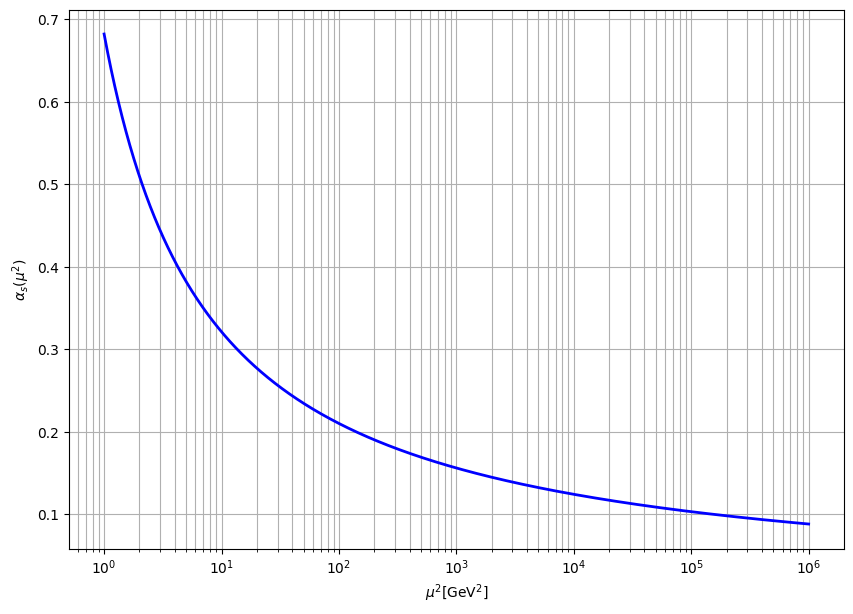

In [4]:
# Log Plot of RGE
# Define the range for x from .5 GeV**2 to 10 GeV**2
mu_values = np.geomspace(1, 10**3, 10**4)
# mu_values = np.linspace(1, 10**2, 10**3)

# Evolve alpha_s from mu=1 GeV**2 on a mu grid
x_alpha_S= evolve_alpha_s(mu_values)

# Create the plot
plt.figure(figsize=(10, 7))

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Plot uv(x)
plt.plot(mu_values**2, x_alpha_S, color="blue", linewidth=2)

# Set plot labels, legend, and grid
plt.xlabel("$\\mu^2[\mathrm{GeV}^2]$")
plt.ylabel("$\\alpha_s(\\mu^2)$")
plt.grid(True,which="both")

# Display the plot
plt.show()

Plots of conformal moments $\mathbb{G}_q(n,\eta,t)$ and their RGE evolution

Momentum space

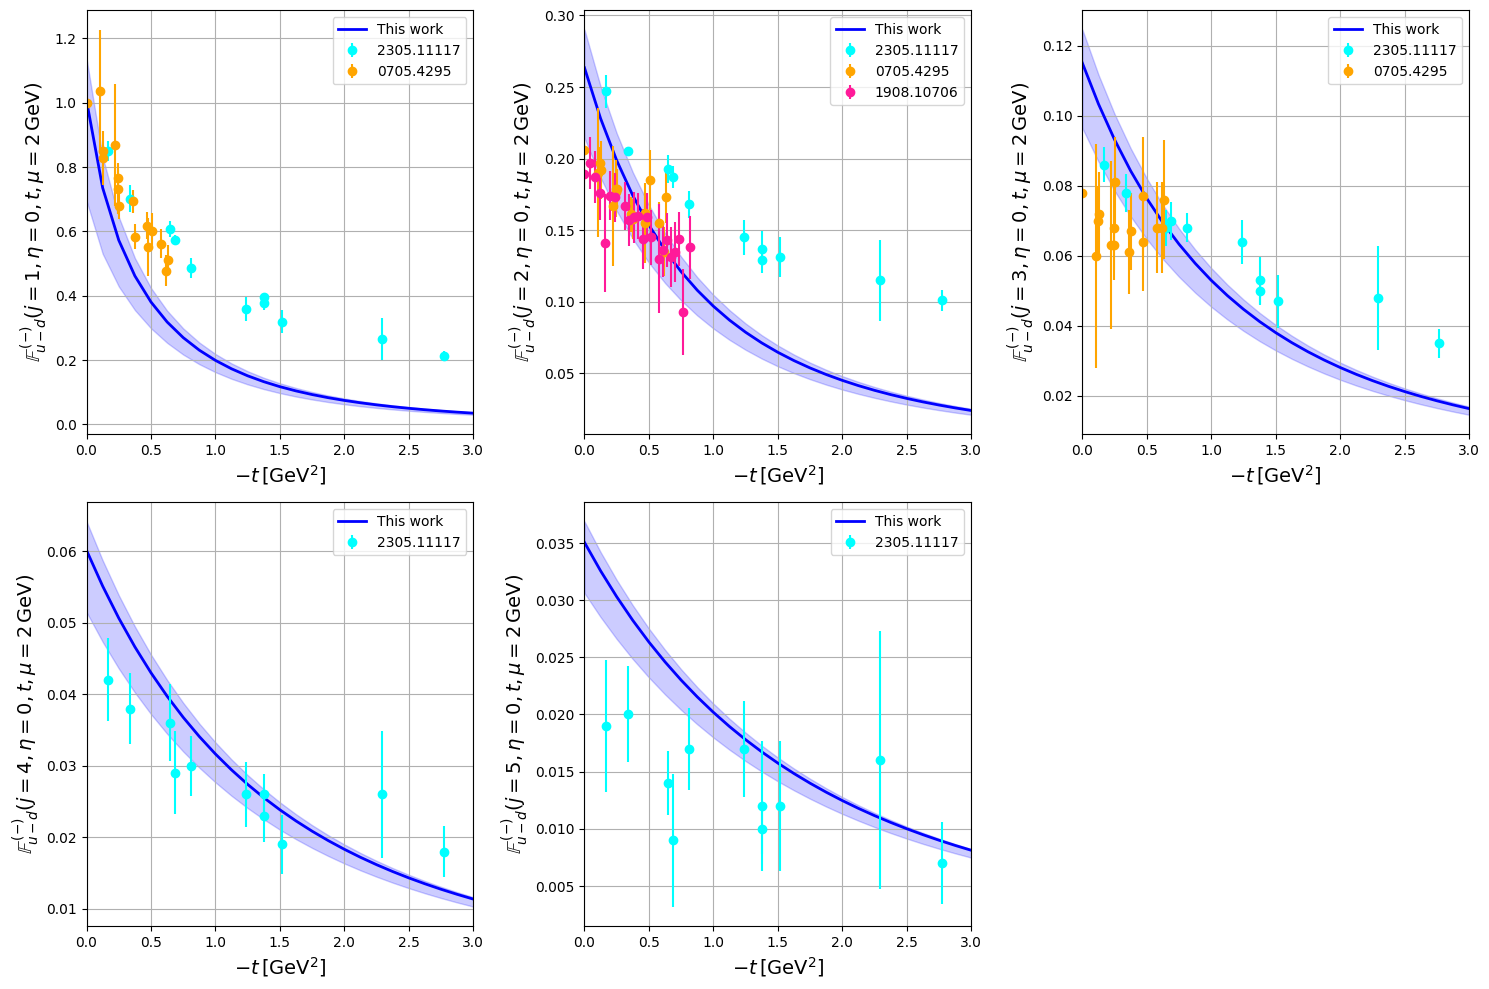

In [ ]:
#NonSingletIsovector
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"

plot_moments(moment_type, moment_label,y_label,3,25)

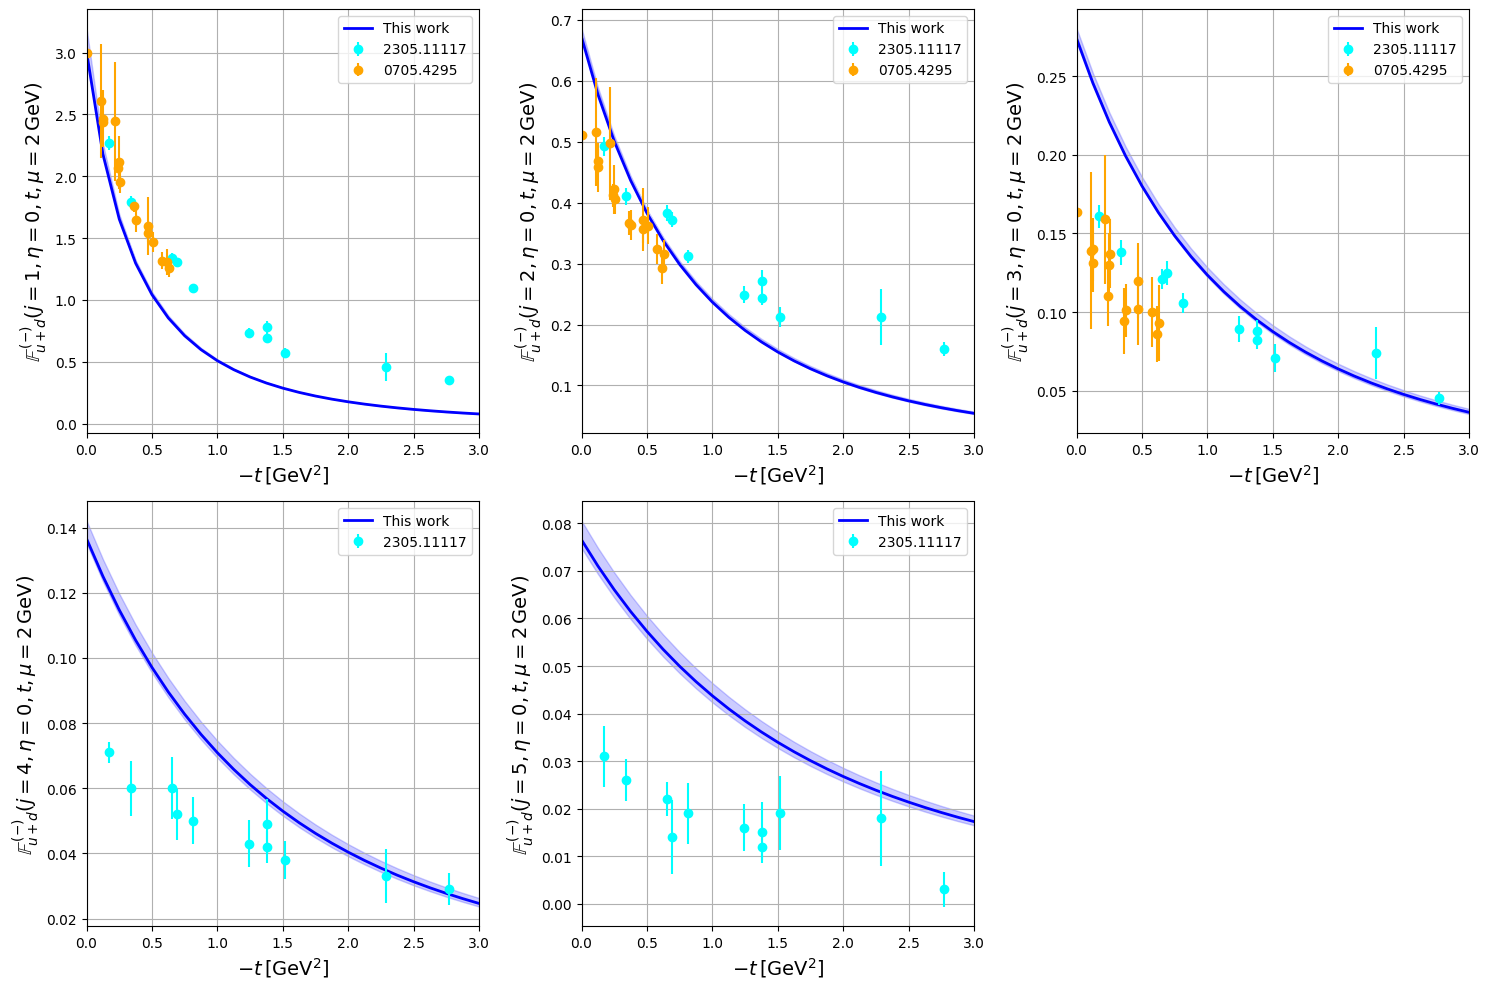

In [3]:
# NonSingletIsoscalar
y_label = "$\\mathbb{{F}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "A"

plot_moments(moment_type, moment_label,y_label,3,25)

Impact parameter representation

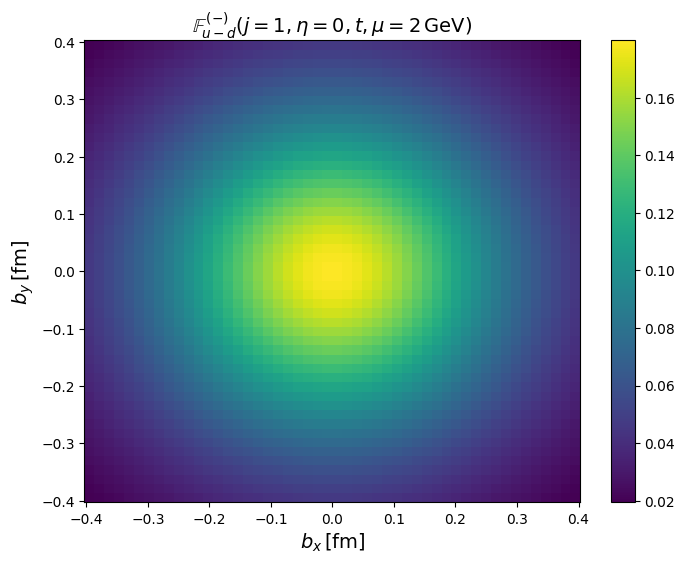

In [4]:
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_title = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
plot_ft_moments(moment_type,moment_label,plot_title, 1, 2)

In [12]:
def diagonal_singlet(j,eta,t,Nf=3,evolve_type="vector",solution="+",error_type="central"):
    # Switch sign
    if solution == "+":
        solution = "-"
    elif solution == "-":
        solution = "+"
    else:
        raise ValueError("Invalid solution type. Use '+' or '-'.")
    if evolve_type == "vector":
        result = (quark_singlet_Regge(j,eta,t,Nf,error_type)
                  + j/6*gamma_qg(j-1,Nf,evolve_type)
                  /(gamma_qq(j-1)-gamma_pm(j-1,Nf,evolve_type,solution))
                  *g_Regge(j,eta,t, error_type))
        return result
    # if evolve_type == "vector":
    #     result = (quark_singlet_Regge(j,eta,t,Nf,error_type)
    #               + 1/6*gamma_qg(j-1,Nf,evolve_type)
    #               /(gamma_qq(j-1)-gamma_pm(j-1,Nf,evolve_type,solution))
    #               *g_Regge(j,eta,t, error_type))
    #     return result
    elif evolve_type == "axial":
        print("Axial is ToDo")
        return 0
    else:
        raise ValueError("Type must be vector or axial")


def diagonal_singlet_A(j,eta,t,Nf=3,evolve_type="vector",solution="+",error_type="central"):
    # Switch sign
    if solution == "+":
        solution = "-"
    elif solution == "-":
        solution = "+"
    else:
        raise ValueError("Invalid solution evolve_type. Use '+' or '-'.")
    if evolve_type == "vector":
        result = (quark_singlet_Regge_A(j,eta,t,Nf,error_type)
                  + j/6*gamma_qg(j-1,Nf,evolve_type)
                  /(gamma_qq(j-1)-gamma_pm(j-1,Nf,evolve_type,solution))
                  *g_Regge_A(j,eta,t, error_type))
        return result
    elif evolve_type == "axial":
        print("Axial is ToDo")
        return 0
    else:
        raise ValueError("Type must be vector or axial")
    
def diagonal_singlet_D(j,eta,t,Nf=3,evolve_type="vector",solution="+",error_type="central"):
    # Switch sign
    if solution == "+":
        solution = "-"
    elif solution == "-":
        solution = "+"
    else:
        raise ValueError("Invalid solution evolve_type. Use '+' or '-'.")
    if evolve_type == "vector":
        result = (quark_singlet_Regge_D(j,eta,t,Nf,error_type)
                  + j/6*gamma_qg(j-1,Nf,evolve_type)
                  /(gamma_qq(j-1)-gamma_pm(j-1,Nf,evolve_type,solution))
                  *g_Regge_D(j,eta,t, error_type))
        return result
    elif evolve_type == "axial":
        print("Axial is ToDo")
        return 0
    else:
        raise ValueError("Type must be vector or axial")

def evolve_quark_singlet(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale to 0.51 @ mu = 2 GeV from 2310.08484
    A0 = 0.51/0.6237
    GPD_in_p = diagonal_singlet(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = gamma_qq(j-1)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (Gamma_pm(j-1,Nf,evolve_type,"-")*evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -Gamma_pm(j-1,Nf,evolve_type,"+")*evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = A0*term_1*term_2
    return result

def evolve_quark_singlet_A(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale to 0.51 @ mu = 2 GeV from 2310.08484
    A0 = 0.51/0.6237
    GPD_in_p = diagonal_singlet_A(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet_A(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = gamma_qq(j-1)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (Gamma_pm(j-1,Nf,evolve_type,"-")*evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -Gamma_pm(j-1,Nf,evolve_type,"+")*evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = A0*term_1*term_2
    return result

def evolve_quark_singlet_D(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale to 0.51 @ mu = 2 GeV from 2310.08484
    D0 = 1.3/1.277
    GPD_in_p = diagonal_singlet_D(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet_D(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = gamma_qq(j-1)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (Gamma_pm(j-1,Nf,evolve_type,"-")*evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -Gamma_pm(j-1,Nf,evolve_type,"+")*evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = D0*term_1*term_2
    return result

def evolve_gluon(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale to 0.501 @ mu = 2 GeV from 2310.08484
    A0 = 0.501/1.018
    GPD_in_p = diagonal_singlet(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = 6/j*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    #term_1 = 6*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = A0*term_1*term_2
    return result
    
def evolve_gluon_A(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale to 0.501 @ mu = 2 GeV from 2310.08484
    A0 = 0.501/1.018
    GPD_in_p = diagonal_singlet_A(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet_A(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = 6/j*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    #term_1 = 6*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = A0*term_1*term_2
    return result

def evolve_gluon_D(j,eta,t,mu,Nf=3,evolve_type="vector",error_type="central"):
    # Manually fix the scale from holography (II.9) in 2204.08857
    D0 = -2.57/8.635
    GPD_in_p = diagonal_singlet_D(j, eta, t, Nf, evolve_type, "+", error_type)
    GPD_in_m = diagonal_singlet_D(j, eta, t, Nf, evolve_type, "-", error_type)
    term_1 = 6/j*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    #term_1 = 6*gamma_gq(j-1,evolve_type)/(gamma_pm(j-1,Nf,evolve_type,"+")-gamma_pm(j-1,Nf,evolve_type,"-"))
    term_2 = (evolve_conformal_moment(GPD_in_p,j-1,mu,Nf,evolve_type,"+")
              -evolve_conformal_moment(GPD_in_m,j-1,mu,Nf,evolve_type,"-"))
    result = D0*term_1*term_2
    return result

In [ ]:
# 0.510024649589122
# 0.5100256941533923
# -1.30044714988575
# 0.50111263175031
# 0.5011083820962285
# -2.57000756593034

In [3]:
print(evolve_quark_singlet(2,1e-3,-0.001,2,3,"vector","central"))
print(evolve_quark_singlet_A(2,1e-3,-0.001,2,3,"vector","central"))
print(evolve_quark_singlet_D(2,1e-3,-0.001,2,3,"vector","central"))
print(evolve_gluon(2,1e-3,-0.001,2,3,"vector","central"))
print(evolve_gluon_A(2,0,-0.001,2,3,"vector","central"))
print(evolve_gluon_D(2,1e-3,-0.001,2,3,"vector","central"))

0.510024649589122
0.5100256941533923
-1.30044714988575
0.50111263175031
0.5011083820962285
-2.57000756593034


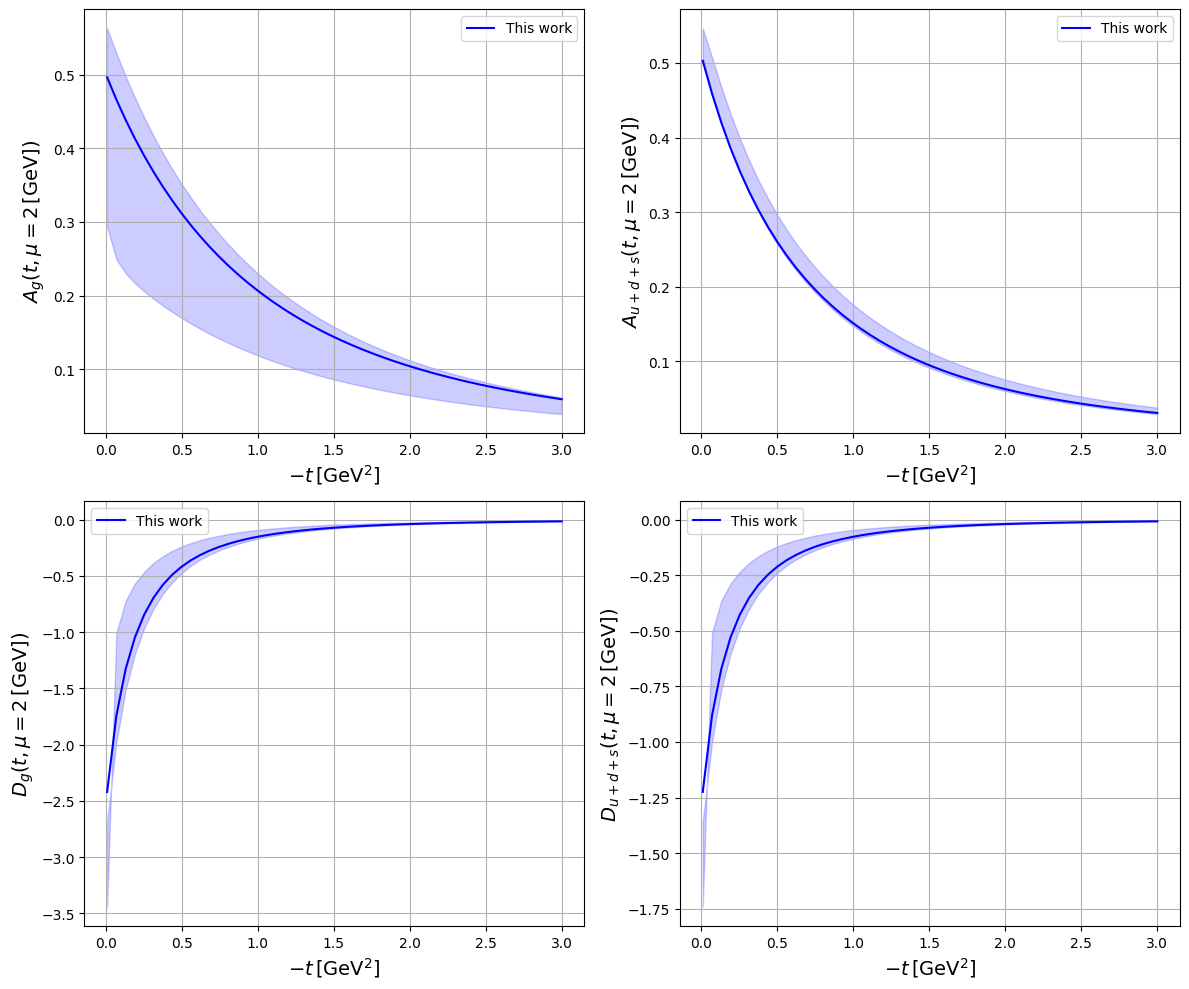

In [4]:
# Plot the evolved singlet conformal moments
def compute_results(evolve_function, j, eta, t_values, mu , Nf = 3, evolve_type = "vector"):
    """Compute central, plus, and minus results for a given evolution function."""
    results = [float(evolve_function(j, eta, t, mu, Nf, evolve_type, "central")) for t in t_values]
    results_plus = [float(evolve_function(j, eta, t, mu, Nf, evolve_type, "plus")) for t in t_values]
    results_minus = [float(evolve_function(j, eta, t, mu, Nf, evolve_type, "minus")) for t in t_values]
    return results, results_plus, results_minus

def plot_results(ax, t_values, results, results_plus, results_minus, xlabel, ylabel):
    """Plot results on the given axis."""
    ax.plot(-t_values, results, label="This work", color="blue")
    ax.fill_between(-t_values, results_minus, results_plus, color="blue", alpha=0.2)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    ax.legend()

def plot_evolve_gluon(t_values):
    """Generate data for the gluon evolution plot."""
    return compute_results(evolve_gluon, 2, 1e-3, t_values, 2, 3, "vector")

def plot_evolve_quark_singlet(t_values):
    """Generate data for the quark singlet evolution plot."""
    return compute_results(evolve_quark_singlet, 2, 1e-3, t_values, 2, 3, "vector")

def plot_evolve_gluon_D(t_values):
    """Generate data for the gluon evolution plot."""
    return compute_results(evolve_gluon_D, 2, 1e-3, t_values, 2, 3, "vector")

def plot_evolve_quark_singlet_D(t_values):
    """Generate data for the quark singlet evolution plot."""
    return compute_results(evolve_quark_singlet_D, 2, 1e-3, t_values, 2, 3, "vector")

# Main script
t_values = np.linspace(-1e-2, -3, 50)  # Generate values of t

# Parallelize data computation
results = Parallel(n_jobs=-1)(
    delayed(func)(t_values) for func in [
        plot_evolve_gluon, 
        plot_evolve_quark_singlet,
        plot_evolve_gluon_D, 
        plot_evolve_quark_singlet_D
    ]
)

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Plot results for each function
plot_results(
    axes[0], t_values, *results[0],
    xlabel="$-t\,[\mathrm{GeV}^2]$",
    ylabel="$A_g(t,\mu = 2\,[\mathrm{GeV}])$",
)
plot_results(
    axes[1], t_values, *results[1],
    xlabel="$-t\,[\mathrm{GeV}^2]$",
    ylabel="$A_{u+d+s}(t,\mu = 2\,[\mathrm{GeV}])$",
)
plot_results(
    axes[2], t_values, *results[2],
    xlabel="$-t\,[\mathrm{GeV}^2]$",
    ylabel="$D_g(t,\mu = 2\,[\mathrm{GeV}])$",
)
plot_results(
    axes[3], t_values, *results[3],
    xlabel="$-t\,[\mathrm{GeV}^2]$",
    ylabel="$D_{u+d+s}(t,\mu = 2\,[\mathrm{GeV}])$",
)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


Define the conformal partial waves

In [27]:
# Define conformal partial waves
def conformal_pw_q(j, x, eta, parity="even"):
    """
    Calculate the conformal partial waves for quark GPDs and generate their
    respective "even" or "odd" combinations.

    Parameters:
    j (complex): Conformal spin
    x (float): Value of parton x
    eta (float): Value of skewness
    parity (str, optional): The parity of the function. Either 'even' or 'odd'. Default is 'even'.

    Returns:
    mpc: Value of even or odd combination of conformal quark partial waves

    Raises:
    ValueError: If the `parity` argument is not "even" or "odd".

    Notes:
    - Branch cut starting at j < 1
    - The result is vectorized later on using np.vectorize for handling array inputs.
    """
    # Precompute factors that do not change
    gamma_term = lambda j: 2.0**j * gamma(1.5 + j) / (gamma(0.5) * gamma(j))
    sin_pi_j = lambda j: np.sin(np.pi * j)
    sin_term = 1 / np.pi  # We divide by sin(pi j) in the SW transform

    def cal_P(x):
        arg = (1. + x / eta)
        hyp = mp.hyp2f1(-j, j + 1, 2, 0.5 * arg)
        result = arg * hyp * gamma_term(j)/sin_pi_j(j)
        return result
    def cal_Q(x): 
        hyp = mp.hyp2f1(0.5 * j, 0.5 * (j + 1), 1.5 + j, (eta / x)**2) 
        result = hyp * sin_term
        return result
    
    if parity not in ["even", "odd","none"]:
        raise ValueError("Parity must be even, odd or none")

    def p_j(x):
        # Initialize P_term and Q_term with zero
        P_term = 0
        Q_term = 0        
        if eta - np.abs(x) >= 0 :  # If condition for cal_P is satisfied
            # Note continuity at x = eta gives cal_P = cal_Q
            P_term = 1 / eta**j * cal_P(x)
        elif x - eta > 0 :
            Q_term = 1 / x**j * cal_Q(x)
        return P_term + Q_term
    
    if parity == "even":    # Even parity
        result = p_j(x) + p_j(-x)
    elif parity == "odd":   # Odd parity
        result = p_j(x) - p_j(-x)
    else :
        result = p_j(x)     # No parity for non_singlet
    conformal_pw = np.complex128(result)
    return conformal_pw
# Vectorize
vectorized_conformal_pw_q = np.vectorize(conformal_pw_q, otypes=[np.complex128])


def conformal_pw_g(j, x, eta, parity="even"):
    """
    Calculate the conformal partial waves for gluon GPDs and generate their
    respective "even" or "odd" combinations.

    Parameters:
    j (complex): Conformal spin
    x (float): Value of parton x
    eta (float): Value of skewness
    parity (str, optional): The parity of the function. Either 'even' or 'odd'. Default is 'even'.

    Returns:
    mpc: Value of even or odd combination of conformal quark partial waves

    Raises:
    ValueError: If the `parity` argument is not "even" or "odd".

    Notes:
    - Branch cut starting at j < 2
    - The result is vectorized later on using np.vectorize for handling array inputs.
    """
    # Precompute factors that do not change
    gamma_term = lambda j: 2.0**(j-1) * gamma(1.5 + j) / (gamma(0.5) * gamma(j-1))
    sin_pi_j = lambda j: np.sin(np.pi * (j))
    sin_term = -1 / np.pi   # We divide by sin(pi j) in the SW transform
                            # sin(pi (j+1))/sin(pi j) = - 1

    def cal_P(x):
        arg = (1. + x / eta)
        hyp = mp.hyp2f1(-j, j + 1, 3, 0.5 * arg)
        result = arg**2 * hyp * gamma_term(j)/sin_pi_j(j)
        return result
    def cal_Q(x): 
        hyp = mp.hyp2f1(0.5 * (j-1), 0.5 * j, 1.5 + j, (eta / x)**2) 
        result = hyp * sin_term
        return result
    
    if parity not in ["even", "odd"]:
        raise ValueError("Parity must be even or odd")

    def p_j(x):
        # Initialize P_term and Q_term with zero
        P_term = 0
        Q_term = 0        
        if eta - np.abs(x) >= 0 :  # If condition for cal_P is satisfied
            P_term = 1 / eta**j * cal_P(x)
        elif x - eta > 0 :
            Q_term = 1 / x**j * cal_Q(x)
        return P_term + Q_term
    
    if parity == "even":
        result = p_j(x) + p_j(-x)
    else:  # Odd parity
        result = p_j(x) - p_j(-x)

    # Convert to np array
    conformal_pw = np.complex128(result)
    return conformal_pw
# Vectorize
vectorized_conformal_pw_g = np.vectorize(conformal_pw_g, otypes=[np.complex128])

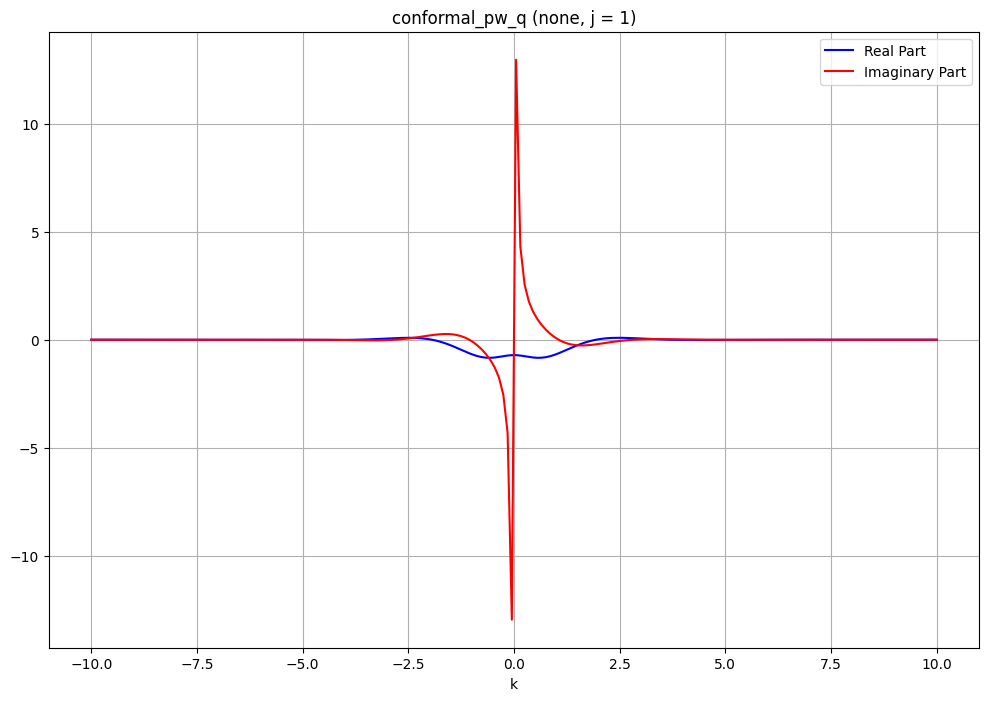

In [28]:
# Plot the partial waves
def plot_conformal_pw_q(x, eta, k_range=(-10, 10), num_points=100, parity="even"):
    """
    Plot the real and imaginary parts of conformal_pw_q function over a range of k values.
    
    Parameters:
    - x: Test value for x.
    - eta: Test value for eta.
    - k_range: Tuple for the range of k values (default is (-10, 10)).
    - num_points: Number of points to plot (default is 100).
    - parity: Parity to use for the function, either "even", "odd" or "none" (default is "even").
    """
    if parity == "even":
        j_base = 2
    elif parity == "odd":
        j_base = 3
    elif parity == "none":
        j_base = 1
    else :
        raise ValueError("Parity must be even, odd or none")
    
    # Define the range for k
    k_values = np.linspace(k_range[0], k_range[1], num_points)  # Values for k between k_range

    # Compute j_val as j_base + 1j * k_values
    j_values = j_base + 1j * k_values

    # Compute the result of conformal_pw_q for each j_val
    result = vectorized_conformal_pw_q(j_values, x, eta, parity=parity)

    # Extract the real and imaginary parts
    real_part = np.real(result)
    imag_part = np.imag(result)
    plt.figure(figsize=(12, 8))
    # Plot the real and imaginary parts
    plt.plot(k_values, real_part, label='Real Part', color='b')
    plt.plot(k_values, imag_part, label='Imaginary Part', color='r')
    plt.xlabel('k')
    plt.title(f'conformal_pw_q ({parity}, j = {j_base})')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_conformal_pw_g(x, eta, k_range=(-10, 10), num_points=100, parity="even"):
    """
    Plot the real and imaginary parts of conformal_pw_g function over a range of k values.
    
    Parameters:
    - x: Test value for x.
    - eta: Test value for eta.
    - k_range: Tuple for the range of k values (default is (-10, 10)).
    - num_points: Number of points to plot (default is 100).
    - parity: Parity to use for the function, either "even" or "odd" (default is "even").
    """
    if parity == "even":
        j_base = 3
    elif parity == "odd":
        j_base = 2
    else :
        raise ValueError("Parity must be even or odd")

    # Define the range for k
    k_values = np.linspace(k_range[0], k_range[1], num_points)  # Values for k between k_range

    # Compute j_val as j_base + 1j * k_values
    j_values = j_base + 1j * k_values

    # Compute the result of conformal_pw_g for each j_val
    result = vectorized_conformal_pw_g(j_values, x, eta, parity=parity)

    # Extract the real and imaginary parts
    real_part = np.real(result)
    imag_part = np.imag(result)
    plt.figure(figsize=(12, 8))
    # Plot the real and imaginary parts
    plt.plot(k_values, real_part, label='Real Part', color='b')
    plt.plot(k_values, imag_part, label='Imaginary Part', color='r')
    plt.title(f"conformal_pw_g({parity}, j = {j_base})")
    plt.xlabel('k')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the plot function for both conformal_pw_q and conformal_pw_g
plot_conformal_pw_q(.1, 1/3, k_range=(-10, 10), num_points=200, parity="none")
# plot_conformal_pw_q(.1, 1/3, k_range=(-10, 10), num_points=200, parity="even")
# plot_conformal_pw_q(.1, 1/3, k_range=(-10, 10), num_points=200, parity="odd")
# plot_conformal_pw_g(.1, 1/3, k_range=(-10, 10), num_points=200, parity="even")
# plot_conformal_pw_g(.1, 1/3, k_range=(-10, 10), num_points=200, parity="odd")


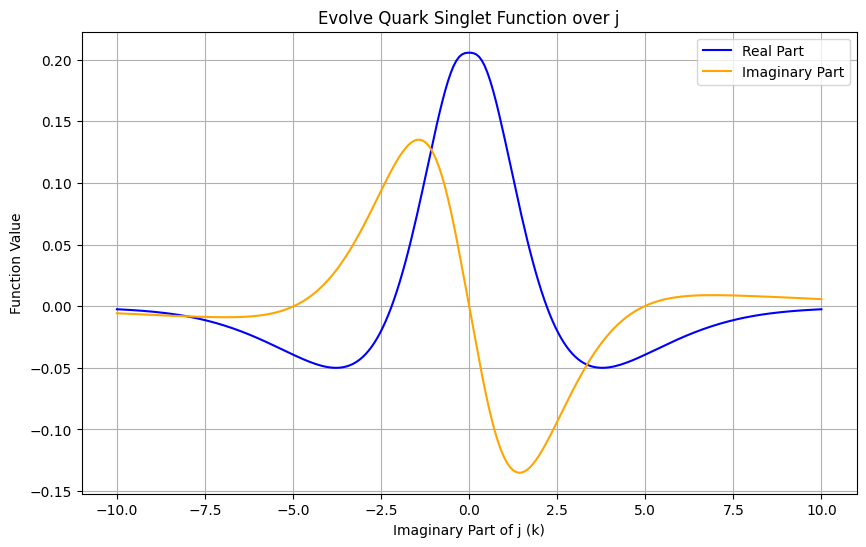

In [35]:
# Plot evolve_quark_singlet over imaginary j
def plot_j_evolve_quark_singlet(eta, t, mu,parity="even"):
    """
    Plots evolve_quark_singlet(j, eta, t, mu) over a complex domain of j.

    Parameters:
    - eta (float): Parameter for the evolve_quark_singlet function.
    - t (float): Parameter for the evolve_quark_singlet function.
    - mu (float): Parameter for the evolve_quark_singlet function.
    """
    # Determine value on the real axis by parity assignment
    if parity == "even":
        j_base = 2
    elif parity == "odd":
        j_base = 3
    else:
        raise ValueError("Parity must be even or odd")
    # Generate j values: j = j_base + 1j * k where -10 <= k <= 10
    k_values = np.linspace(-10, 10, 250)
    j_values = j_base + 1j * k_values

    # Compute the function values in parallel
    results = Parallel(n_jobs=-1)(delayed(evolve_quark_singlet)(j, eta, t, mu,evolve_type = "vector") for j in j_values)

    # Separate the real and imaginary parts for plotting
    real_parts = [np.real(r) for r in results]
    imag_parts = [np.imag(r) for r in results]

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(k_values, real_parts, label='Real Part', color='blue')
    plt.plot(k_values, imag_parts, label='Imaginary Part', color='orange')

    plt.title('Evolve Quark Singlet Function over j')
    plt.xlabel('Imaginary Part of j (k)')
    plt.ylabel('Function Value')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage
eta = 1/3
t = -1e-2
mu = 2
plot_j_evolve_quark_singlet(eta, t, mu,"odd")


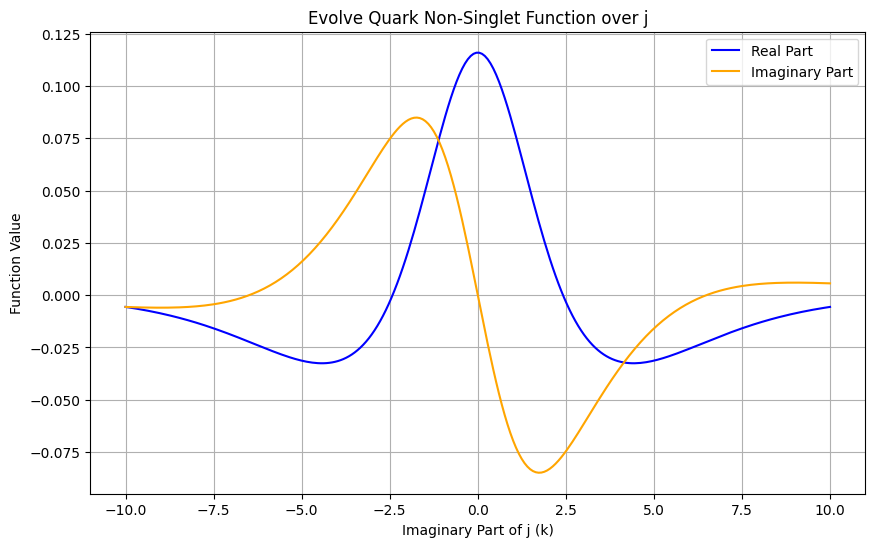

In [ ]:
# Plot evolve_quark_non_singlet over imaginary j
def plot_j_evolve_quark_non_singlet(eta, t, mu,parity="even"):
    """
    Plots evolve_quark_singlet(j, eta, t, mu) over a complex domain of j.

    Parameters:
    - eta (float): Parameter for the evolve_quark_singlet function.
    - t (float): Parameter for the evolve_quark_singlet function.
    - mu (float): Parameter for the evolve_quark_singlet function.
    """
    # Determine value on the real axis by parity assignment
    if parity == "even":
        j_base = 2
    elif parity == "odd":
        j_base = 3
    else:
        raise ValueError("Parity must be even or odd")
    # Generate j values: j = j_base + 1j * k where -10 <= k <= 10
    k_values = np.linspace(-10, 10, 250)
    j_values = j_base + 1j * k_values

    # Compute the function values in parallel
    results = Parallel(n_jobs=-1)(delayed(evolve_quark_non_singlet)(j,eta,t,mu,evolve_type = "NonSingletIsovector") for j in j_values)

    # Separate the real and imaginary parts for plotting
    real_parts = [np.real(r) for r in results]
    imag_parts = [np.imag(r) for r in results]

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(k_values, real_parts, label='Real Part', color='blue')
    plt.plot(k_values, imag_parts, label='Imaginary Part', color='orange')

    plt.title('Evolve Quark Non-Singlet Function over j')
    plt.xlabel('Imaginary Part of j (k)')
    plt.ylabel('Function Value')
    plt.legend()
    plt.grid(True)

    plt.show()

# Example usage
eta = 1/3
t = 1e-2
mu = 2
plot_j_evolve_quark_non_singlet(eta, t, mu,"odd")


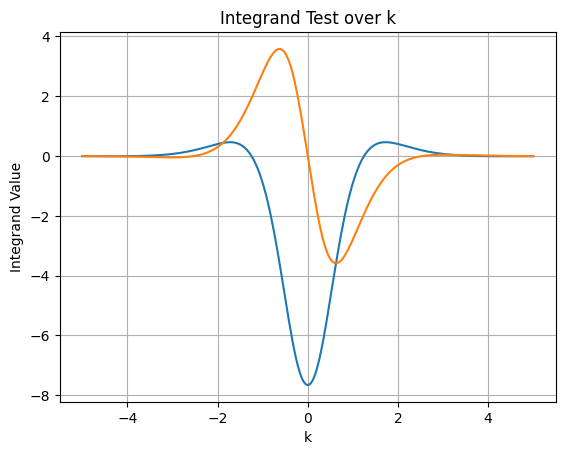

In [47]:
# Plot integrand over k
def integrand_test(k,x,eta, t, mu, Nf=3, evolve_type="vector", parity="even", error_type="central"):
    # Determine value on the real axis by parity assignment
    if parity == "even":
        j_min = 2
    elif parity == "odd":
        j_min = 3
    else:
        raise ValueError("Parity must be even or odd")
    z = j_min + 1j * k
    dz = 1j
    pw_val = conformal_pw_q(z, x, eta, parity)
    mom_val = evolve_quark_singlet(z,eta,t,mu,Nf,evolve_type,error_type)
    result = -.5j*dz * pw_val * mom_val
    return np.complex128(result)

# Parallelize the function over k values
def parallel_integrand(k_values,parity="even"):
    # Example parameters (replace with actual values)
    x = .1
    eta = 1/3
    t = -1e-2
    mu = 2
    Nf = 3
    evolve_type = "vector"
    error_type="central"
    results = Parallel(n_jobs=-1)(delayed(integrand_test)(k, x, eta, t, mu, Nf, evolve_type, parity, error_type) for k in k_values)
    return np.array(results)

k_values = np.linspace(-5, 5, 250)
results = parallel_integrand(k_values,"odd")
# Plot the results
plt.plot(k_values, results.real)
plt.plot(k_values, results.imag)
plt.xlabel('k')
plt.ylabel('Integrand Value')
plt.title('Integrand Test over k')
plt.grid(True)
plt.show()
del k_values, results

In [43]:
# Mellin-Barnes integral with parallelization over k-values
def mellin_barnes_singlet_q(j_max, x, eta, t, mu, Nf=3, evolve_type="vector", parity="even", error_type="central", n_jobs=-1,n_k = 800,real_imag ="real"):
    """
    Numerically evaluate the Mellin-Barnes integral parallel to the imaginary axis
    
    Parameters:
    - j_max (float): Integration range parallel to the imaginary axis
    - x (float): Parton x
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <=3 ): Number of flavors
    - evolve_type (str): Evolve axial or vector GPDs
    - parity (str): Parity to use for the partial wave combinations, either "even" or "odd" (default is "even").
    - error_type (str): value of input PDFs (central, plus, minus)
    - n_jobs (int): Number of subregions, and thus processes, the integral is split into
    - n_k (int): Number of sampling points within the interval [-j_max,j_max]
    - real_imag (str): Choose to compute real, imaginary part or both
    Returns: 
    - The value of the Mellin barnes integral with real and imaginary part.
    """
    # Integrand function which returns both real and imaginary parts
    def integrand(k):

        z = j_min + 1j * k
        dz = 1j
        pw_val = conformal_pw_q(z, x, eta, parity)
        mom_val = evolve_quark_singlet(z, eta, t, mu, Nf, evolve_type, error_type)
        result = -.5j * dz * pw_val * mom_val
        return np.float64(result.real), np.float64(result.imag)  # Return both real and imaginary parts

    # Function to integrate over a subinterval of k and extract real and imaginary parts
    def integrate_subinterval(k_values):
        k_min = k_values[0]
        k_max = k_values[-1]
        
        # Define the integrand function that returns both real and imaginary parts
        def combined_integrand(k):
            real_part, imag_part = integrand(k)  # Call the integrand function once
            return real_part, imag_part
        
        # Define the real part integrand function for quad
        def real_part_integrand(k):
            real_part, _ = combined_integrand(k)  # Extract real part
            return real_part
        
        # Define the imaginary part integrand function for quad
        def imag_part_integrand(k):
            _, imag_part = combined_integrand(k)  # Extract imaginary part
            return imag_part
        
        # Integrate real and imaginary parts using quad
        if real_imag == "real":
            real_part, real_error = quad(real_part_integrand, k_min, k_max)
            return real_part, real_error
        elif real_imag == "imag":   
            imag_part, imag_error = quad(imag_part_integrand, k_min, k_max)
            return imag_part, imag_error
        elif real_imag == "both":
            real_part, real_error = quad(real_part_integrand, k_min, k_max)
            imag_part, imag_error = quad(imag_part_integrand, k_min, k_max)
            return real_part, real_error, imag_part, imag_error 
        else :
            raise ValueError("real_imag must be either real, imag or both")

    if parity == "even":
        j_min = 2
    elif parity == "odd":
        j_min = 3
    else :
        raise ValueError("Parity must be even or odd")

    k_range = np.linspace(-j_max, j_max,n_k)

    # Define the number of subintervals (equal to n_jobs)
    n_subintervals = n_jobs if n_jobs > 0 else os.cpu_count()  # Default to all cores if n_jobs isn't specified
    k_values_split = np.array_split(k_range, n_subintervals)

    # Parallelize the integration over the subintervals of k
    results = Parallel(n_jobs=n_subintervals)(
        delayed(integrate_subinterval)(k_values_split[i]) for i in range(n_subintervals)
    )

    if real_imag == "both":
        real_integral = sum(result[0] for result in results)
        real_error = np.sqrt(sum(result[1]**2 for result in results))
        imag_integral = sum(result[2] for result in results)
        imag_error = np.sqrt(sum(result[3]**2 for result in results))
        integral = real_integral +1j * imag_integral
        error = real_error + 1j * imag_error
    else :
    # Sum the results from all subintervals for real and imaginary parts, and accumulate the errors
        integral = sum(result[0] for result in results)
        error = np.sqrt(sum(result[1]**2 for result in results))

    # Check for the estimated error
    if np.abs(error) > 1e-3:
        print(f"Warning: Large error estimate: {error}")

    return integral

# Mellin-Barnes integral with parallelization over k-values
def mellin_barnes_non_singlet_q(j_max, x, eta, t, mu, Nf=3, error_type="central", n_jobs=-1,n_k = 800,real_imag ="real"):
    """
    Numerically evaluate the Mellin-Barnes integral parallel to the imaginary axis
    
    Parameters:
    - j_max (float): Integration range parallel to the imaginary axis
    - x (float): Parton x
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <=3 ): Number of flavors
    - evolve_type (str): Evolve axial or vector GPDs
    - parity (str): Parity to use for the partial wave combinations, either "even" or "odd" (default is "even").
    - error_type (str): value of input PDFs (central, plus, minus)
    - n_jobs (int): Number of subregions, and thus processes, the integral is split into
    - n_k (int): Number of sampling points within the interval [-j_max,j_max]
    - real_imag (str): Choose to compute real, imaginary part or both
    Returns: 
    - The value of the Mellin barnes integral with real and imaginary part.
    """
    # Integrand function which returns both real and imaginary parts
    def integrand(k):
        z = j_min + 1j * k
        dz = 1j
        pw_val = conformal_pw_q(z, x, eta, "none")
        mom_val = evolve_quark_non_singlet(z,eta,t,mu,evolve_type="NonSingletIsovector")
        result = -.5j * dz * pw_val * mom_val
        return np.float64(result.real), np.float64(result.imag)  # Return both real and imaginary parts

    # Function to integrate over a subinterval of k and extract real and imaginary parts
    def integrate_subinterval(k_values):
        k_min = k_values[0]
        k_max = k_values[-1]
        
        # Define the integrand function that returns both real and imaginary parts
        def combined_integrand(k):
            real_part, imag_part = integrand(k)  # Call the integrand function once
            return real_part, imag_part
        
        # Define the real part integrand function for quad
        def real_part_integrand(k):
            real_part, _ = combined_integrand(k)  # Extract real part
            return real_part
        
        # Define the imaginary part integrand function for quad
        def imag_part_integrand(k):
            _, imag_part = combined_integrand(k)  # Extract imaginary part
            return imag_part
        
        # Integrate real and imaginary parts using quad
        if real_imag == "real":
            real_part, real_error = quad(real_part_integrand, k_min, k_max)
            return real_part, real_error
        elif real_imag == "imag":   
            imag_part, imag_error = quad(imag_part_integrand, k_min, k_max)
            return imag_part, imag_error
        elif real_imag == "both":
            real_part, real_error = quad(real_part_integrand, k_min, k_max)
            imag_part, imag_error = quad(imag_part_integrand, k_min, k_max)
            return real_part, real_error, imag_part, imag_error 
        else :
            raise ValueError("real_imag must be either real, imag or both")

    j_min = 1

    k_range = np.linspace(-j_max, j_max,n_k)

    # Define the number of subintervals (equal to n_jobs)
    n_subintervals = n_jobs if n_jobs > 0 else os.cpu_count()  # Default to all cores if n_jobs isn't specified
    k_values_split = np.array_split(k_range, n_subintervals)

    # Parallelize the integration over the subintervals of k
    results = Parallel(n_jobs=n_subintervals)(
        delayed(integrate_subinterval)(k_values_split[i]) for i in range(n_subintervals)
    )

    if real_imag == "both":
        real_integral = sum(result[0] for result in results)
        real_error = np.sqrt(sum(result[1]**2 for result in results))
        imag_integral = sum(result[2] for result in results)
        imag_error = np.sqrt(sum(result[3]**2 for result in results))
        integral = real_integral +1j * imag_integral
        error = real_error + 1j * imag_error
    else :
    # Sum the results from all subintervals for real and imaginary parts, and accumulate the errors
        integral = sum(result[0] for result in results)
        error = np.sqrt(sum(result[1]**2 for result in results))

    # Check for the estimated error
    if np.abs(error) > 1e-3:
        print(f"Warning: Large error estimate: {error}")

    return integral



In [44]:
mellin_barnes_non_singlet_q(7.5,.1,1/3,-1e-2,2,real_imag="both")

(0.12830433741868116-5.97818481526337e-14j)

In [45]:
# def mellin_barnes_singlet_q(param1, x, eta, t, mu, parity="odd",real_imag = "real"):
#     """
#     Generic test implementation of mellin_barnes_singlet_q.
#     Returns an exponential function for testing purposes.
#     """
#     return np.exp(-x**2) * np.sin(np.sqrt(x))

def plot_mellin_barnes_singlet_q(real_imag="real",sampling = "true"):
    """
    Plot the real or imaginary part of the Mellin-Barnes singlet Q function
    with dynamically adjusted x intervals.
    """
    # Fix parameters
    eta = 1e-2
    t = -1e-3
    mu = 2
    n_points = 25  # Total number of points to maintain
    n_init = 10  # Sample size

    # Define the initial range for x
    x_0, x_1 = 0.05, 0.7
    if sampling == "true":
        x_values = np.linspace(x_0, x_1 , n_init)

        # Adjust x_values dynamically based on differences in function values
        # Measure time for sampling initial points
        start_time_sampling = time.time()
        results = [mellin_barnes_singlet_q(7.5, x, eta, t, mu,real_imag = real_imag) for x in x_values]
        end_time_sampling = time.time()        

        # Compute differences and scale intervals
        diffs = np.abs(np.diff(results))
        scaled_intervals = diffs / np.sum(diffs)
        cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

        # Output sampling time
        print(f"Time for initial sampling: {end_time_sampling - start_time_sampling:.6f} seconds")

    # Measure time for adaptive grid computation
    start_time_adaptive = time.time()
    if sampling == "true":
        x_values = np.interp(np.linspace(0, 1, n_points), cumulative_intervals, x_values)
    else :
        x_values = np.linspace(x_0, x_1 , n_points)
    results = [mellin_barnes_singlet_q(7.5, x, eta, t, mu,real_imag = real_imag) for x in x_values]
    end_time_adaptive = time.time()

    real_parts = np.real(results)
    imag_parts = np.imag(results)

    # Output plot generation time
    print(f"Time for plot computation: {end_time_adaptive - start_time_adaptive:.6f} seconds")

    # Plot the chosen part
    if real_imag == "real":
        plt.scatter(x_values, real_parts, label='Real Part', color='b', s=10)
        plt.title('Real Part of Sea Quark GPD')
    elif real_imag == "imag":
        plt.scatter(x_values, imag_parts, label='Imaginary Part', color='r', s=10)
        plt.title('Imaginary Part of Sea Quark GPD')
    elif real_imag =="both":
        plt.scatter(x_values, real_parts, label='Real Part', color='b', s=10)
        plt.scatter(x_values, imag_parts, label='Imaginary Part', color='r', s=10)
        plt.title('Real and Imaginary Part of Sea Quark GPD')

    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_mellin_barnes_non_singlet_q(real_imag="real",sampling = "true"):
    """
    Plot the real or imaginary part of the Mellin-Barnes singlet Q function
    with dynamically adjusted x intervals.
    """
    # Fix parameters
    eta = 1e-2
    t = -1e-3
    mu = 2
    n_points = 50  # Total number of points to maintain
    n_init = 10  # Sample size

    # Define the initial range for x
    x_0, x_1 = 0.05, 0.7
    if sampling == "true":
        x_values = np.linspace(x_0, x_1 , n_init)

        # Adjust x_values dynamically based on differences in function values
        # Measure time for sampling initial points
        start_time_sampling = time.time()
        results = [mellin_barnes_non_singlet_q(7.5, x, eta, t, mu,real_imag = real_imag) for x in x_values]
        end_time_sampling = time.time()        

        # Compute differences and scale intervals
        diffs = np.abs(np.diff(results))
        scaled_intervals = diffs / np.sum(diffs)
        cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

        # Output sampling time
        print(f"Time for initial sampling: {end_time_sampling - start_time_sampling:.6f} seconds")

    # Measure time for adaptive grid computation
    start_time_adaptive = time.time()
    if sampling == "true":
        x_values = np.interp(np.linspace(0, 1, n_points), cumulative_intervals, x_values)
    else :
        x_values = np.linspace(x_0, x_1 , n_points)
    results = [mellin_barnes_non_singlet_q(7.5, x, eta, t, mu,real_imag = real_imag) for x in x_values]
    end_time_adaptive = time.time()

    real_parts = np.real(results)
    imag_parts = np.imag(results)

    # Output plot generation time
    print(f"Time for plot computation: {end_time_adaptive - start_time_adaptive:.6f} seconds")

    # Plot the chosen part
    if real_imag == "real":
        plt.scatter(x_values, real_parts, label='Real Part', color='b', s=10)
        plt.title('Real Part of Non-Singlet Isovector GPD')
    elif real_imag == "imag":
        plt.scatter(x_values, imag_parts, label='Imaginary Part', color='r', s=10)
        plt.title('Imaginary Part of Non-Singlet Isovector GPD')
    elif real_imag =="both":
        plt.scatter(x_values, real_parts, label='Real Part', color='b', s=10)
        plt.scatter(x_values, imag_parts, label='Imaginary Part', color='r', s=10)
        plt.title('Real and Imaginary Part of Non-Singlet Isovector GPD')

    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()

#plot_mellin_barnes_singlet_q()
#plot_mellin_barnes_singlet_q(sampling = "false")

Time for initial sampling: 1.775111 seconds
Time for plot computation: 10.005836 seconds


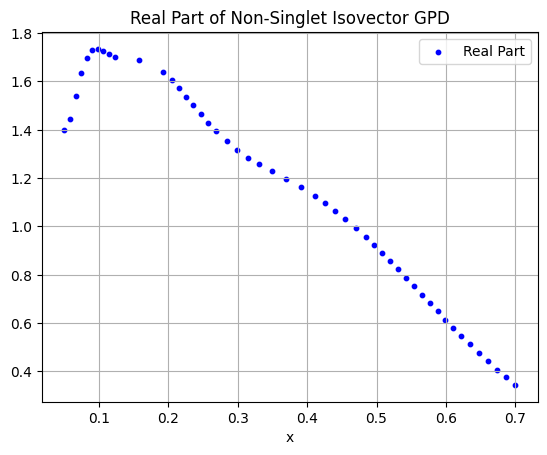

In [46]:
plot_mellin_barnes_non_singlet_q()